In [55]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
from keras.backend import clear_session
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences
# https://realpython.com/python-keras-text-classification/

In [5]:
file_path = {'amazon': './data/sentiment labelled sentences/amazon_cells_labelled.txt',
             'imdb': './data/sentiment labelled sentences/imdb_labelled.txt',
             'yelp': './data/sentiment labelled sentences/yelp_labelled.txt'}

In [6]:
df_list = []
for source, fp in file_path.items():
    df = pd.read_csv(fp, names=['sentence', 'label'], sep='\t')
    df['source'] = source
    df_list.append(df)

In [8]:
df = pd.concat(df_list)

In [29]:
df

,sentence,label,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
995,I think food should have flavor and texture an...,0,yelp
996,Appetite instantly gone.,0,yelp
997,Overall I was not impressed and would not go b...,0,yelp
998,"The whole experience was underwhelming, and I ...",0,yelp


In [26]:
sentences_train, sentences_test, y_train, y_test = train_test_split(df['sentence'], df['label'], test_size=0.25, random_state=4)

In [27]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [28]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8369723435225619


In [30]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487
Accuracy for yelp data: 0.7960


In [33]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                17150     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 17,161
Trainable params: 17,161
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(X_train, y_train, epochs=100, verbose=False, validation_data=(X_test, y_test), batch_size=10)

/opt/homebrew/Caskroom/miniforge/base/envs/regular/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
2022-05-26 20:53:14.721506: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [37]:
clear_session()

In [38]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7920


In [44]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

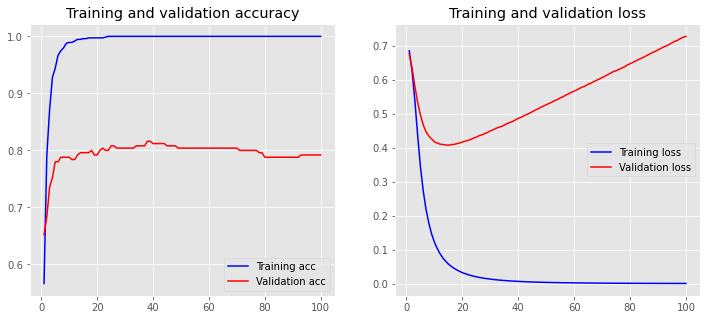

In [45]:
plot_history(history)

In [48]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

In [49]:
encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [51]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(sentences_train[2])
print(X_train[2])

Of all the dishes, the salmon was the best, but all were great.
[11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]


In [52]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 43
happy: 320
sad: 450


In [54]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  1  10   3 282 739  25   8 208  30  64 459 230  13   1 124   5 231   8
  58   5  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [56]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           87350     
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 10)                50010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 137,371
Trainable params: 137,371
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.5067
Testing Accuracy:  0.4800


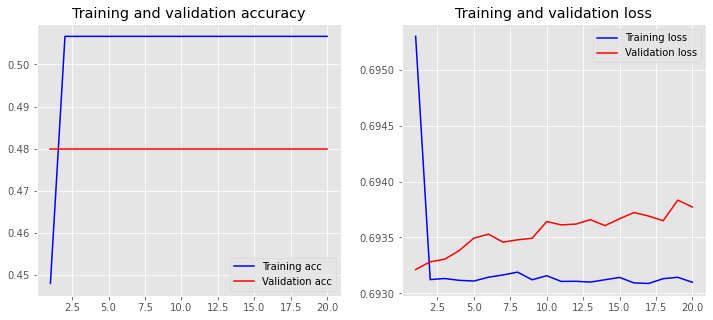

In [57]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [58]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           87350     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8160


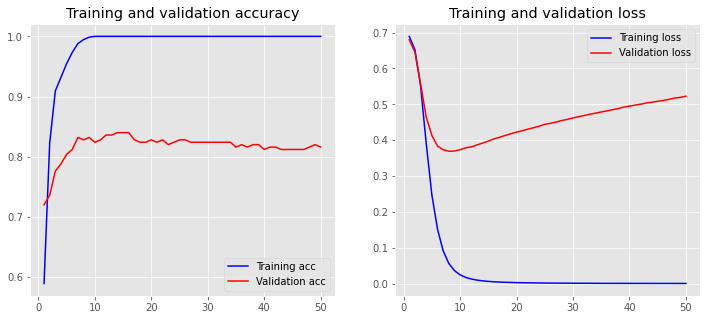

In [59]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)